<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Membres du groupe

**Minimum 2, Maximum 3**

<span style="color:red">
    Répondre ci-dessous
</span>

* Hamrouni, Cheima
* MSallem, Soufian
* Makoundou, Chloe

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, vous devrez prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

Le but de ce TP est de travailler sur un challenge de prédiction de la mortalité.

Le lien vers le challenge :
https://codalab.lisn.upsaclay.fr/competitions/3739

* **Étape 1 :** S'enregistrer sur https://codalab.lisn.upsaclay.fr

* **Étape 2:** Téléchargez le jeu de données à partir de la [page](https://codalab.lisn.upsaclay.fr/competitions/3739#participate-get_starting_kit) "Participate > Files > Public Data".

* **Étape 3:** Parcourez ce notebook. Vous devrez lire, exécuter, **coder vos propres méthodes** et **répondre aux questions**. Utilisez la cellule ***code*** pour le codage et la cellule ***markdown*** pour répondre aux questions.

## Évaluation du projet

* **4 points** pour la partie compréhension et analyse exploratoire
    
* **4 points** pour un code propre et bien documenté

* **4 points** pour la qualité du modèle (sélection du modèle, sélection des hyperparamètres)

* **4 points** pour une bonne évaluation des performances du modèle

* **4 points** pour la qualité de la présentation orale 

* **1 point bonus** pour l'équipe gagnante du challenge

### FAQ

* Soumettre uniquement le notebook sur eCampus

* La partie texte (explications, résultats, problèmes, sans le code) ne doit pas dépasser 3 pages A4 11pt (< 1500 mots)

# Challenge

Module requis : `imblearn` (à installer avec `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
!pip install imbalanced-learn
from datetime import datetime
from pathlib import Path

import seaborn as sns
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
  Using cached scikit_learn-1.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.4 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0
    Uninstalling scikit-learn-1.0:
      Successfully uninstalled scikit-learn-1.0


In [2]:
%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

## 1. Compréhension du problème

### Expliquez brièvement la tâche avec vos mots

<span style="color:red">
    Répondre ci-dessous
</span>

La tâche consiste à prédire la survie des patients à l'hopital. Pour cela, on prend toutes les données des patients (une dataframe) qu'on va entraîner sur un modèle et les tester. On regarde la coorélation entre les données et on en enlève si on ne les juge pas utile. Le but est d'avoir un score élevé pour prouver l'efficacité du modèle.

### Métrique utilisée

Pourquoi la métrique utilisée ici est la [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) plutôt que simplement l'[`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ?

<span style="color:red">
    Répondre ci-dessous
</span>

Parce que SMBAS donne une balanced accuracy lorsqu'on a une base de donnée pas équilibré alors que SMAS donne un calcule sur la précision du sous-ensemble. L'ensemble d'étiquettes prédit pour un échantillon doit correspondre exactement à l'ensemble d'étiquettes correspondant.

## 2. Chargement des données

In [3]:
#DATA = Path("~/ownCloud/EDU/Courses/L2-ISD2/Project/public_data").expanduser()
DATA = Path("data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

#assert DATA.is_dir()

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


C'est **l'ensemble d'entrainement**. Cela signifie que vous avez accès aux étiquettes et que vous pouvez l'utiliser comme vous le souhaitez pour préparer votre modèle.

Plus tard, vous ferez en sorte que votre modèle tire des prédictions de **l'ensemble de test** afin de les téléverser sur Codalab et d'obtenir un score sur des données non vues lors de l'entrainement des modèles.

In [6]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_VARS, inplace=True)

## 3. Analyse exploratoire

#### Types des variables

In [7]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

#### Distribution de la variable cible

In [8]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

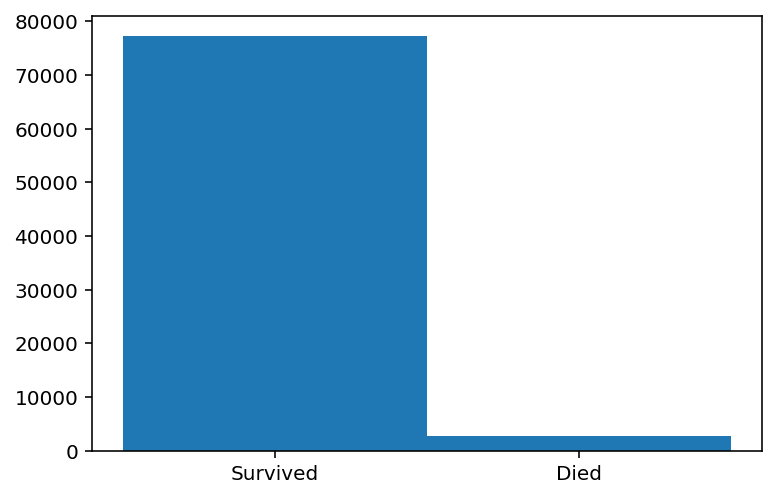

In [9]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
# plt.savefig("img/tobe.png", dpi=300)
plt.show()

### Code : Produire les graphiques suivants

* Diagrammes à barres de certaines variables catégorielles (par exemple "LANGUAGE", "MARITAL_STATUS")

* Montrez la corrélation entre certaines variables et la variable cible y

* Un autre graphique ou toute analyse exploratoire à laquelle vous pouvez penser

Exemple

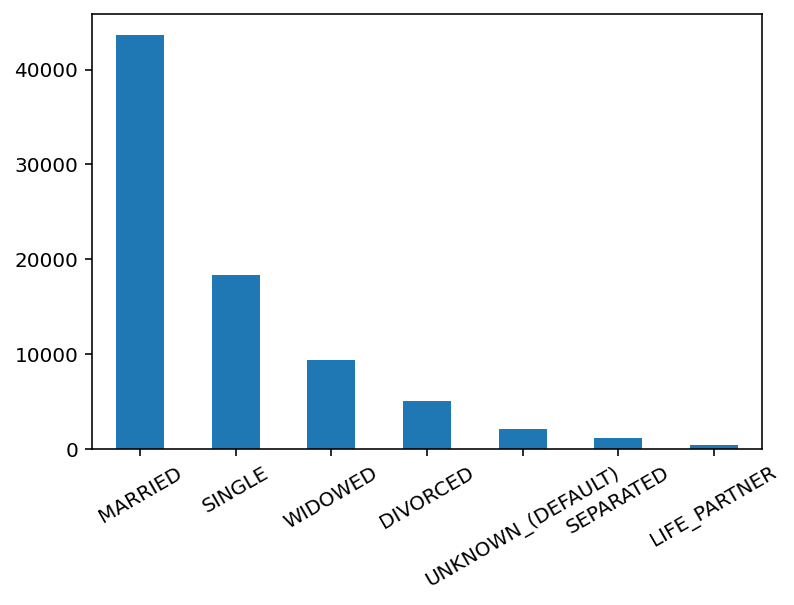

In [10]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

<span style="color:red">
    Répondre ci-dessous
</span>

<AxesSubplot:>

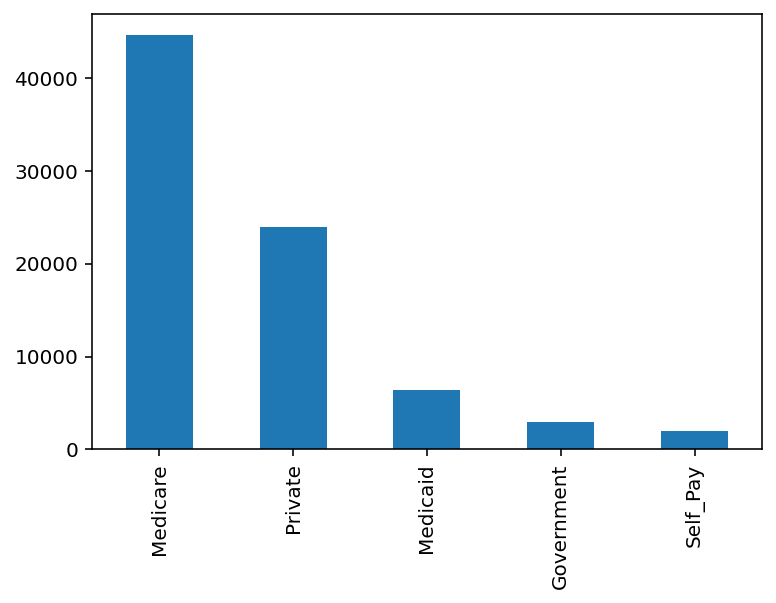

In [11]:
# TODO: Bar plot of another variable

x_df['INSURANCE'].value_counts().plot(kind='bar', rot = 90)

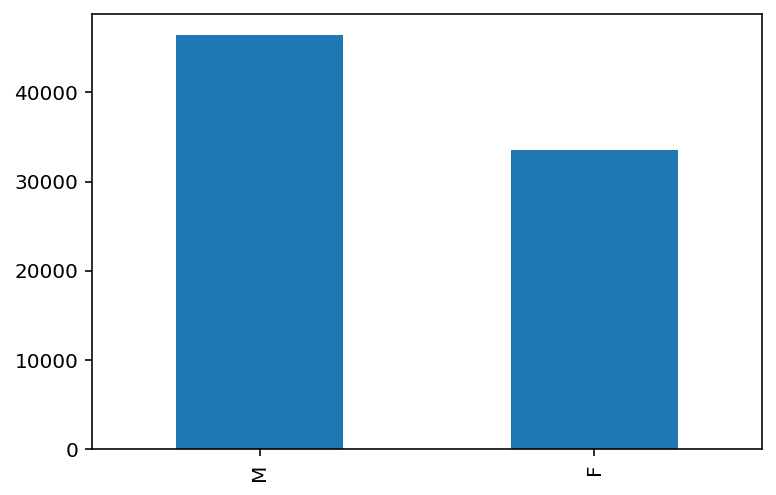

In [12]:
# TODO: Bar plot of another variable

x_Gender = x_df['GENDER'].value_counts().plot(kind='bar', rot = 90)

#### Corrélations

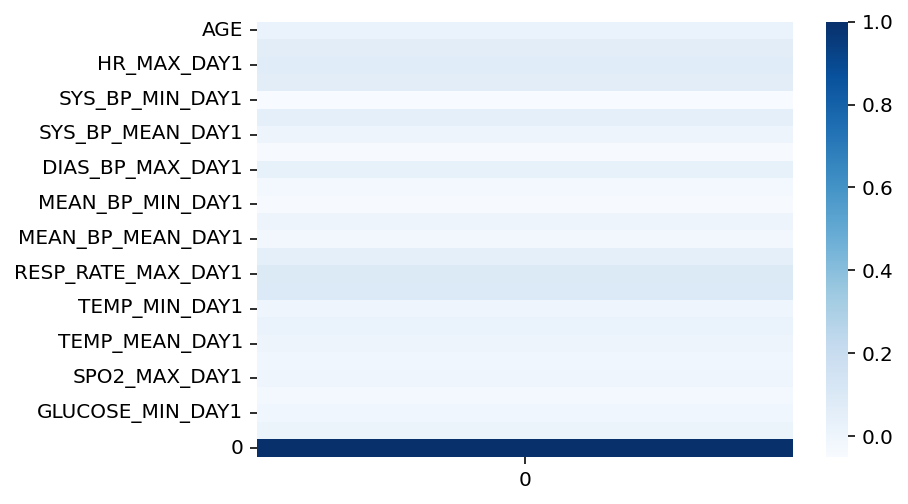

In [13]:
# TODO: Bar plot of the variables most correlated with y

result = pd.concat([x_df[x_df.columns[0:30]], ys], axis=1).corr()

result = result.loc[0]

result = result.to_frame()

sns.heatmap(result, cmap="Blues")

#sns.heatmap(result)

plt.show()

Astuce :

* Utilisez un graphique avec des barres horizontales `barh` (pour visualiser les valeurs positives et négatives)

<AxesSubplot:>

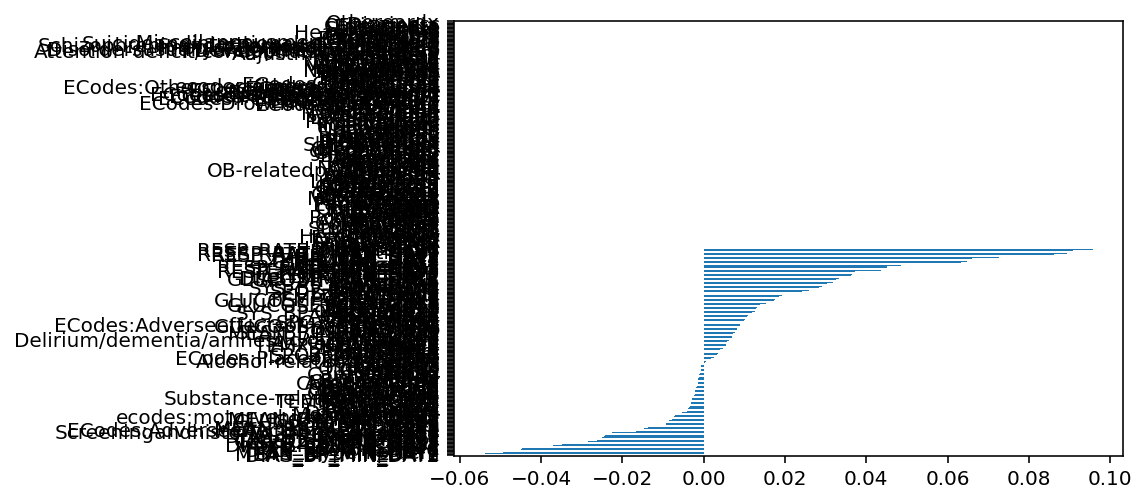

In [14]:
x_df.corrwith(ys).sort_values().plot(kind = 'barh')

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Il y a trop de données dans ce graphique. Nous voyons également qu'il manque des barres horizontale vers le debut de notre graphique. Peut-être qu'on a pas de données pour ces variables?


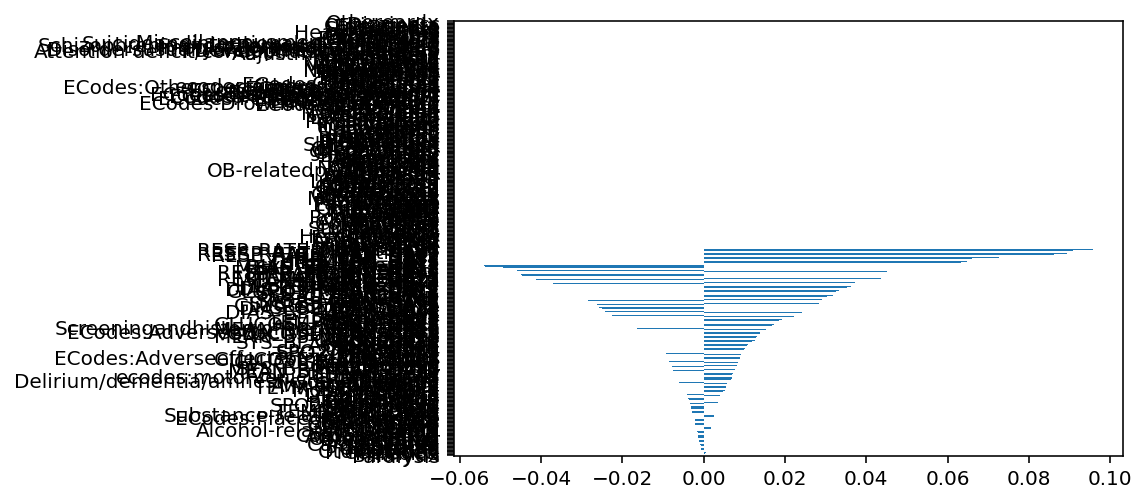

In [15]:
x_df.corrwith(ys).sort_values(key = abs, ascending = True).plot(kind = 'barh')
plt.show()

<AxesSubplot:>

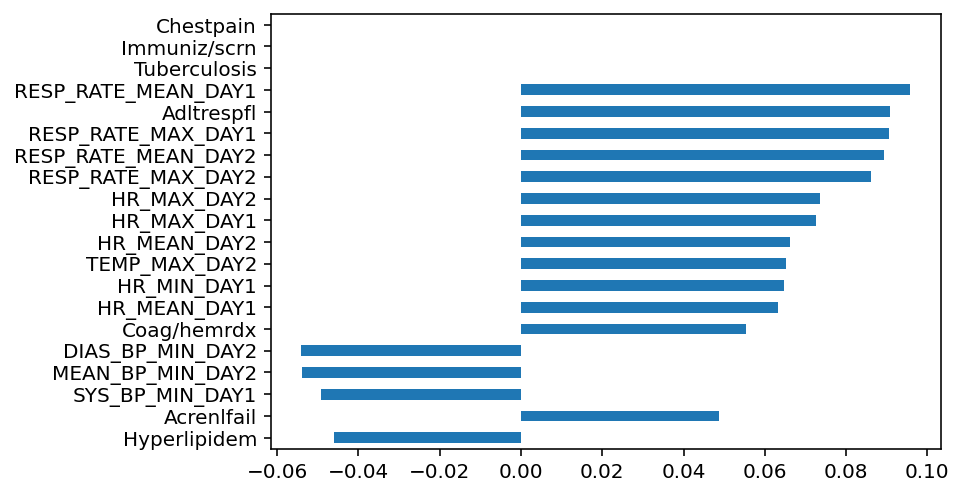

In [16]:
x_df.corrwith(ys).sort_values(key = abs, ascending = True)[140:160].plot(kind = 'barh')

#### Autres graphiques ou résultats d'une analyse exploratoire

<AxesSubplot:title={'left':'graphique des assurance des patients'}>

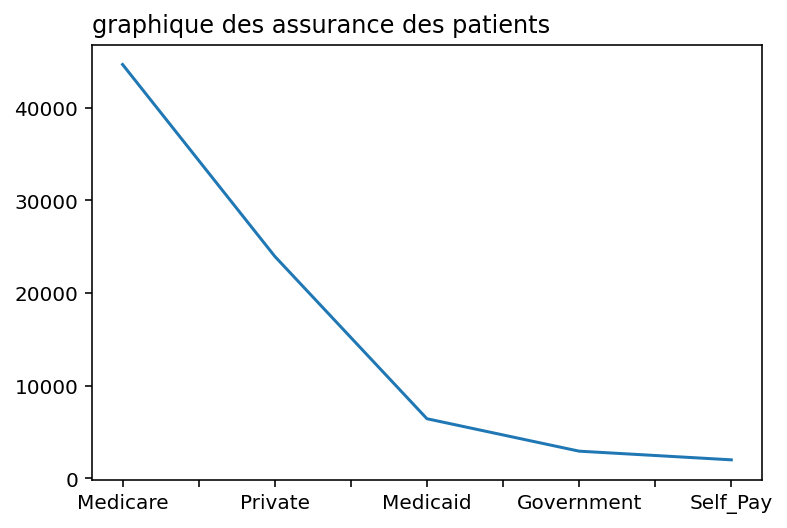

In [17]:
plt.title("graphique des assurance des patients", loc = "left")
x_df['INSURANCE'].value_counts().plot(kind='line')

<AxesSubplot:title={'left':'Diagramme circulaire des religions des patients'}, ylabel='INSURANCE'>

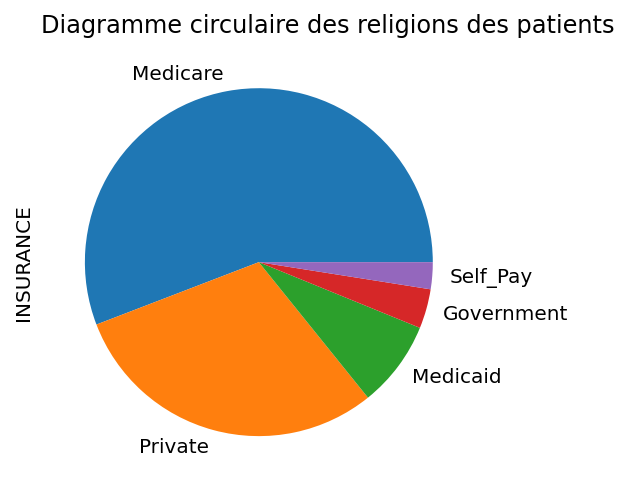

In [18]:
plt.title("Diagramme circulaire des religions des patients", loc = "left")
x_df['INSURANCE'].value_counts().plot(kind='pie')

<AxesSubplot:title={'left':'Diagramme circulaire du genre'}, ylabel='GENDER'>

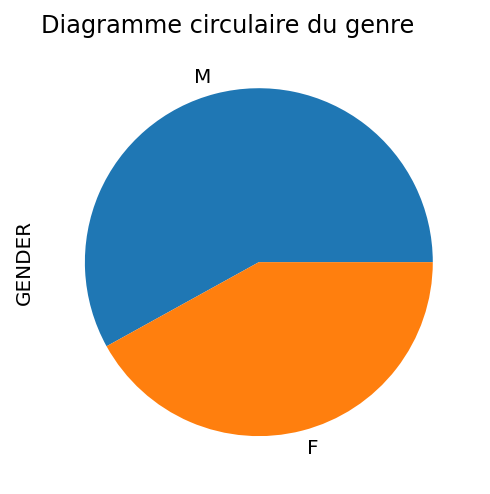

In [19]:
plt.title("Diagramme circulaire du genre", loc = "left")
x_df['GENDER'].value_counts().plot(kind='pie')

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Nous remarquons que plusieurs patients ont une assurance de type Medicare, et nous voyons aussi que la majorité des patients sont de genre masculin

## 4. Pre-traitement

### Code : Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que nous choisissons ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable. Comme ces valeurs manquantes concernent exclusivement des variables catégorielles et binaires, la valeur la plus probable est le *mode* (voir cours : `part-5-slides.pdf`).

In [20]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


In [21]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [22]:
x_test_nans = x_test_df.isna().sum()
x_test_miss = x_test_nans[x_test_nans > 0]
x_test_miss

LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64

In [23]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [24]:
na_cols = set(x_miss.index) | set(x_test_miss.index)

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)
    x_test_df[col].fillna(x_test_df[col].mode()[0], inplace=True)

In [25]:
print(
    x_df.isna().any().any(),
    x_test_df.isna().any().any(),
    sep="\n",
)

False
False


In [26]:
print(x_df.shape, x_test_df.shape)

(79999, 337) (20001, 337)


### Gestion des catégories rares

Simplifiez les données en regroupant par exemple les catégories rares.

In [27]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df, x_test_df], col="RELIGION", keep_n=5)
print(x_test_df["RELIGION"].value_counts())

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object')
CATHOLIC             7517
NOT_SPECIFIED        3764
OTHER                2449
UNOBTAINABLE         2208
PROTESTANT_QUAKER    2208
JEWISH               1855
Name: RELIGION, dtype: int64


#### Code : Effectuez des regroupements de catégories rares pour d'autres variables si vous le jugez nécessaire

<span style="color:red">
    Répondre ci-dessous
</span>

In [28]:
# TODO: Other application of merge_rare_categories

merge_rare_categories([x_df, x_test_df], col="LANGUAGE", keep_n=6)
print(x_test_df["LANGUAGE"].value_counts())

Index(['ENGL', 'SPAN', 'RUSS', 'PTUN', 'CANT', 'PORT'], dtype='object')
ENGL     18883
OTHER      416
SPAN       258
RUSS       151
PTUN       147
CANT        77
PORT        69
Name: LANGUAGE, dtype: int64


### Transformation des données catégorielles en nombres entiers en utilisant deux types d'encodage

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

#### Encodage numérique simple

Deux des méthodes les plus simples sont `LabelEncoder` de Scikit-Learn et `factorize` de pandas. Elles consistent simplement à remplacer chaque nouvelle catégorie rencontrée par un entier, en commençant par 0. Ce n'est cependant peut-être pas la méthode la plus efficace, car elle présuppose une proximité entre les catégories codées avec des valeurs proches.

In [29]:
def label_encode(df, other_df, only_binary=False):

    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index
    # print(char_cols)

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes

            # Create conversion dic to convert values of test set as well
            cat2code = {k: v for v, k in enumerate(uniques)}
            other_df[col] = other_df[col].map(cat2code)

In [30]:
x_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [31]:
print(x_df.shape, ys.shape)

(79999, 337) (79999,)


In [32]:
x_fact_df = x_df.copy()
x_test_fact_df = x_test_df.copy()

label_encode(x_fact_df, x_test_fact_df)

In [33]:
x_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,0,0,0,0,0,0,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,2,1,1,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


In [34]:
x_test_fact_df.head(3)

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,3,0,5,3,0,0,18,72.6,113,96.5,...,0,0,0,0,0,0,0,0,0,0
1,2,0,2,1,4,0,56,66.6,107,83.8,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,1,32,69.7,103,87.3,...,0,0,0,0,0,0,0,0,0,0


#### Encodage 1-Hot

Un autre type d'encodage est souvent plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [35]:
codes, uniques = pd.factorize(x_df["MARITAL_STATUS"])
cat2code = {k: v for v, k in enumerate(uniques)}
cat2code

{'DIVORCED': 0,
 'SINGLE': 1,
 'WIDOWED': 2,
 'MARRIED': 3,
 'UNKNOWN_(DEFAULT)': 4,
 'SEPARATED': 5,
 'LIFE_PARTNER': 6}

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [36]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, x_test_df, only_binary=True)

x_all_oh_df = pd.get_dummies(pd.concat([x_df, x_test_df]))

x_oh_df = x_all_oh_df.iloc[: len(x_df)].copy()
x_test_oh_df = x_all_oh_df.iloc[len(x_df):].copy()

print(x_df.shape, x_test_df.shape)
print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 337) (20001, 337)
(79999, 402) (20001, 402)


#### Suppression des variables à valeur unique (constantes)

In [37]:
const_cols = {col for col in x_oh_df if len(x_oh_df[col].unique()) == 1}
len(const_cols)

173

In [38]:
x_oh_df.drop(const_cols, axis="columns", inplace=True)
x_test_oh_df.drop(const_cols, axis="columns", inplace=True)

print(x_oh_df.shape, x_test_oh_df.shape)

(79999, 229) (20001, 229)


### Création de l'ensemble de validation

In [39]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_oh_df, ys, test_size=0.3
)
# VARS: x_df, x_fact_df, x_oh_df

### Réduction de la dimension via l'ACP (PCA)

Testez l'ACP pour réduire le nombre de dimensions et observez si cela améliore le résultat.

Avant d'appliquer la ACP, il est conseillé de centrer-réduire les données (e.g., via `preprocessing.StandardScaler()`).

<span style="color:red">
    Répondre ci-dessous
</span>

In [40]:
# TODO: PCA

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

In [41]:
# TODO: Plot

# Importer le PCA
from sklearn.decomposition import PCA

# Déclare le PCA
pca = PCA(n_components=2)

# Fit avec les datas 
pca.fit(x_train)

# Transformer les données
xs = pca.transform(x_train)

Proposez un graphique qui représente les 2 premières dimensions de la PCA et commentez succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

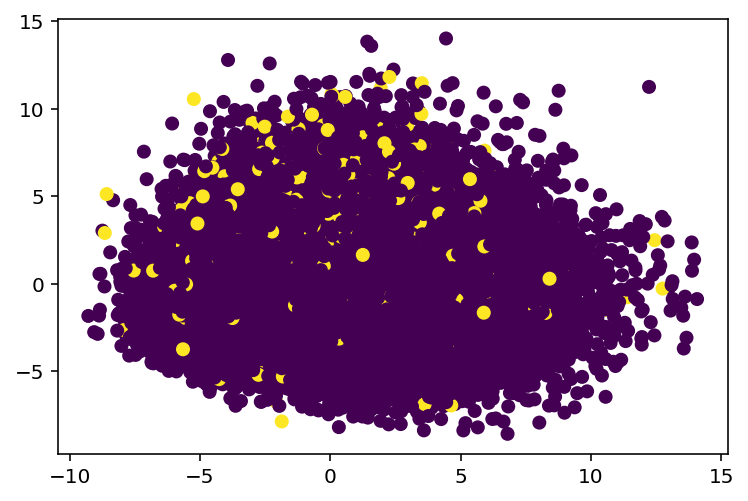

In [42]:
plt.scatter(xs[:,0], xs[:,1], c = y_train)

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Nous pouvons voir que nous avons un scatterplot avec beaucoup de violet et moins de point jaune, ce qui nous montre les 2 premieres dimensions de la PCA. L'ACP est notamment utilisée pour visualiser des corrélations entre les variables, et identifier des groupes homogènes ou à l'inverse des observations atypiques, en particulier des profils à première vue "cachés" à l'intérieur d'un jeu de données. Comme nous avons vu dans le l'histogramme les point jaune sont les personnes "décédés" et les violettes "vivant"

## 5. Modèles de classification

Entrainez le modèle

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [43]:
SCORINGS = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [44]:
# logisticRegression

model_2 = linear_model.LogisticRegression(max_iter=10000)

# RandomForestClassifier

model = ensemble.RandomForestClassifier(n_estimators=10)

# TODO: Try other models

model.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

In [45]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier

/opt/conda/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [46]:
# TODO: Try other models

# Bayes Gaussian
models = naive_bayes.GaussianNB()

# Hist Gradient Boosting Classifier
model2 = HistGradientBoostingClassifier(max_iter = 250)

In [47]:
# ---------Etape 3 : Apprentissage

# logisticRegression
model_2.fit(x_train, y_train)

# Bayes Gaussian
models.fit(x_train, y_train)

# Hist Gradient Boosting Classifier
model2.fit(x_train, y_train)

HistGradientBoostingClassifier(max_iter=250)

## 6. Évaluations

In [48]:
# -----------Etape 4 : predire

# logisticRegression
ys_predict2 = model_2.predict(x_valid)

# Bayes Gaussian
ys_predict = models.predict(x_valid)

# Hist Gradient Boosting Classifier
y2_pred = model2.predict(x_valid)

# RandomForestClassifier
y_pred = model.predict(x_valid)  # predictions

score1 = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring RandomForestClassifier
score2 = metrics.balanced_accuracy_score(y_valid, ys_predict2)  # scoring logisticRegression
score3 = metrics.balanced_accuracy_score(y_valid, ys_predict)  # scoring Bayes Gaussian
score4 = metrics.balanced_accuracy_score(y_valid, y2_pred)  # scoring Hist Gradient Boosting Classifier


In [49]:
print(f"Balanced accuracy score1: {score1:.3g}")
print(f"Balanced accuracy score2: {score2:.3g}")
print(f"Balanced accuracy score3: {score3:.3g}")
print(f"Balanced accuracy score4: {score4:.3g}")
y_valid.value_counts()

Balanced accuracy score1: 0.501
Balanced accuracy score2: 0.529
Balanced accuracy score3: 0.5
Balanced accuracy score4: 0.515


0    23193
1      807
dtype: int64

### Code : Validation croisée

Le code ci-dessus utilise une méthode simple (*hold out*) pour mesurer le score de validation. Utilisez la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

Vous pouvez changer la valeur du nombre de validation croisée (CV) selon la valeur de l'erreur et le temps d'entrainement des modèles (compromis).

In [50]:
CV = 10
SCORING = "balanced_accuracy"

<span style="color:red">
    Répondre ci-dessous
</span>

In [51]:
# TODO: Cross-Validation

from sklearn.model_selection import cross_val_score
res = cross_val_score(model, x_train, y_train, cv=CV, scoring=SCORINGS, verbose = 10)
res

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.505) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


[CV] END ................................ score: (test=0.502) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.2s remaining:    0.0s


[CV] END ................................ score: (test=0.502) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.8s remaining:    0.0s


[CV] END ................................ score: (test=0.502) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.1s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   5.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   32.4s remaining:    0.0s


[CV] END ................................ score: (test=0.505) total time=   5.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   38.0s remaining:    0.0s


[CV] END ................................ score: (test=0.502) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   43.4s remaining:    0.0s


[CV] END ................................ score: (test=0.503) total time=   5.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   48.9s remaining:    0.0s


[CV] END ................................ score: (test=0.503) total time=   5.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   54.0s finished


array([0.505, 0.5  , 0.502, 0.502, 0.502, 0.5  , 0.505, 0.502, 0.503,
       0.503])

In [52]:
# TODO: Cross-Validation

res2 = cross_val_score(model_2, x_train, y_train, cv=CV, scoring=SCORINGS, verbose = 10)
res2

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.532) total time=   1.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] END ................................ score: (test=0.517) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END ................................ score: (test=0.532) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s


[CV] END ................................ score: (test=0.527) total time=   1.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s


[CV] END ................................ score: (test=0.537) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s remaining:    0.0s


[CV] END ................................ score: (test=0.517) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s


[CV] END ................................ score: (test=0.530) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.7s remaining:    0.0s


[CV] END ................................ score: (test=0.524) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.5s remaining:    0.0s


[CV] END ................................ score: (test=0.534) total time=   0.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.1s remaining:    0.0s


[CV] END ................................ score: (test=0.514) total time=   1.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.4s finished


array([0.532, 0.517, 0.532, 0.527, 0.537, 0.517, 0.53 , 0.524, 0.534,
       0.514])

In [53]:
# TODO: Cross-Validation

res3 = cross_val_score(models, x_train, y_train, cv=CV, scoring=SCORINGS, verbose = 10)
res3

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.501) total time=   1.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] END ................................ score: (test=0.501) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV] END ................................ score: (test=0.498) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV] END ................................ score: (test=0.497) total time=   0.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s


[CV] END ................................ score: (test=0.501) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.6s remaining:    0.0s


[CV] END ................................ score: (test=0.491) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.1s remaining:    0.0s


[CV] END ................................ score: (test=0.498) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.5s remaining:    0.0s


[CV] END ................................ score: (test=0.497) total time=   0.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s


[CV] END ................................ score: (test=0.496) total time=   0.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


array([0.501, 0.501, 0.498, 0.497, 0.501, 0.5  , 0.491, 0.498, 0.497,
       0.496])

In [54]:
# TODO: Cross-Validation
from sklearn.model_selection import cross_val_score
res4 = cross_val_score(model2, x_train, y_train, cv=CV, scoring=SCORINGS, verbose = 10)
res4

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.522) total time=28.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.2min remaining:    0.0s


[CV] END ................................ score: (test=0.509) total time=35.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 63.4min remaining:    0.0s


[CV] END ................................ score: (test=0.517) total time=46.9min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 110.3min remaining:    0.0s


[CV] END ................................ score: (test=0.519) total time=16.5min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 126.9min remaining:    0.0s


[CV] END ................................ score: (test=0.525) total time=20.1min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 146.9min remaining:    0.0s


[CV] END ................................ score: (test=0.524) total time=35.8min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 182.7min remaining:    0.0s


[CV] END ................................ score: (test=0.524) total time= 4.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 186.9min remaining:    0.0s


[CV] END ................................ score: (test=0.532) total time=   9.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 187.1min remaining:    0.0s


[CV] END ................................ score: (test=0.522) total time=   9.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 187.2min remaining:    0.0s


[CV] END ................................ score: (test=0.522) total time=   8.4s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 187.3min finished


array([0.522, 0.509, 0.517, 0.519, 0.525, 0.524, 0.524, 0.532, 0.522,
       0.522])

* **Pour 2 des modèles** (au moins 1 autre que les 2 proposés en baselines) :

    * Pour différentes valeurs d'un des hyperparamètres, donnez les `balanced_accuracy` moyennes de la validation croisée sous forme de Boxplots (ou de diagramme à bâtons avec une barre d'erreur) : voir l'exemple présenté dans le graphique ci-dessous. 
    
    * Explicitez succinctement quelles observations en tirer concernant la stabilité des prédictions.

![](img/boxplot-cv.png)

<span style="color:red">
    Répondre ci-dessous
</span>

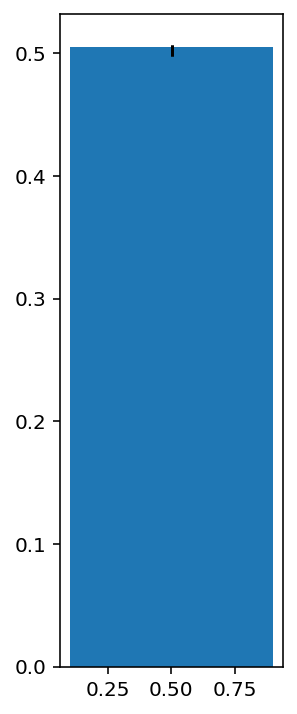

In [55]:
plt.figure(figsize=(2,6))
plt.bar(np.mean(res), res, yerr=np.std(res))
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

nous avons donc dees balanced accuracy moyennes de la validation croisée qui tourne autour de 0.51 ce qui est pas très consequent.

* **Pour chacun de ces 2 modèles, à partir des données de validation créées précédemment** (`x_valid`, `y_valid`) :

    * Mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn (`roc_auc_score`) et comparez les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat.

<span style="color:red">
    Répondre ci-dessous
</span>

In [56]:
# TODO: Confusion Mtx

import numpy as np
from sklearn import metrics

mtx = metrics.roc_auc_score(y_valid, y_pred)
mtx2 = metrics.roc_auc_score(y_valid, ys_predict)
mtx3 = metrics.roc_auc_score(y_valid, ys_predict2)
mtx4 = metrics.roc_auc_score(y_valid, y2_pred)


print(mtx)
print(mtx2)
print(mtx3)
print(mtx4)

0.5005549040001654
0.4997271161004386
0.5286403072841007
0.5152682749265617


<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Nous voyons que entre les différents modèles, on a pas une grande variation des score sauf pour RandomForestClassifier qui est de 0.61..

* **Pour le modèle et sa combinaison d'hyperparamètres offrant le meilleur résultat** :

    * Réalisez la matrice de confusion et décrivez-la succinctement.

<span style="color:red">
    Répondre ci-dessous
</span>

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


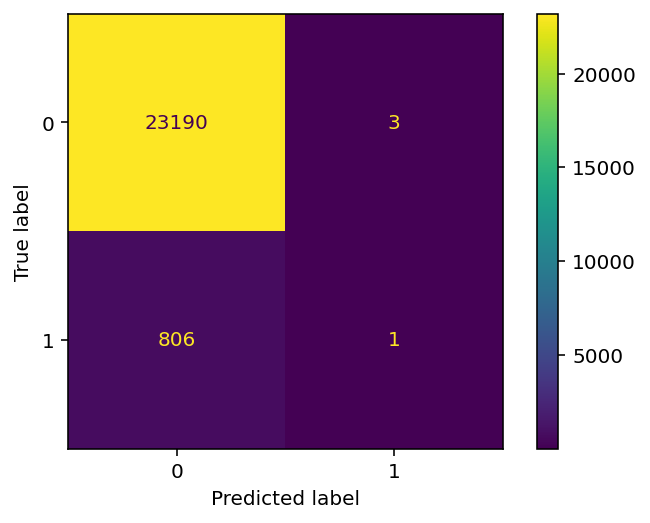

In [57]:
# TODO: ROC

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, x_valid, y_valid)
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


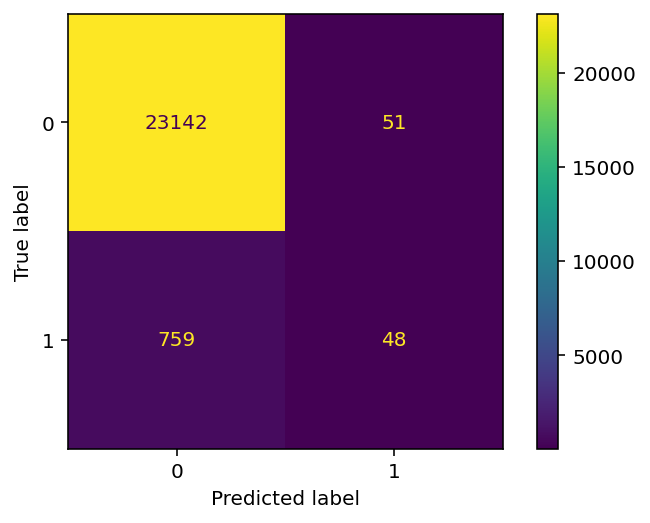

In [58]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_2, x_valid, y_valid)
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


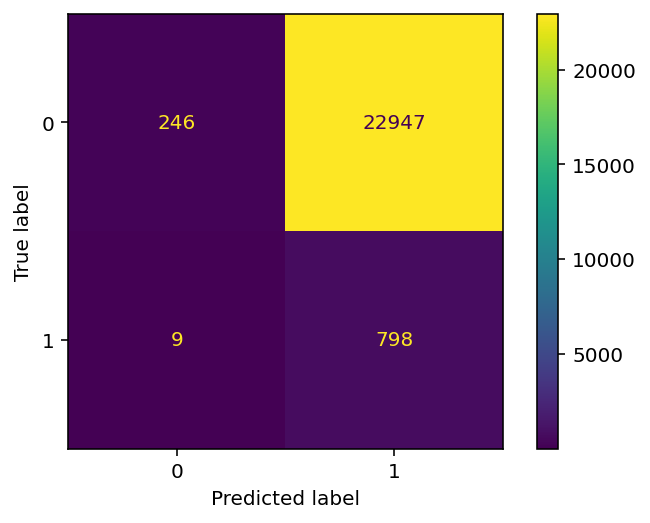

In [59]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(models, x_valid, y_valid)
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


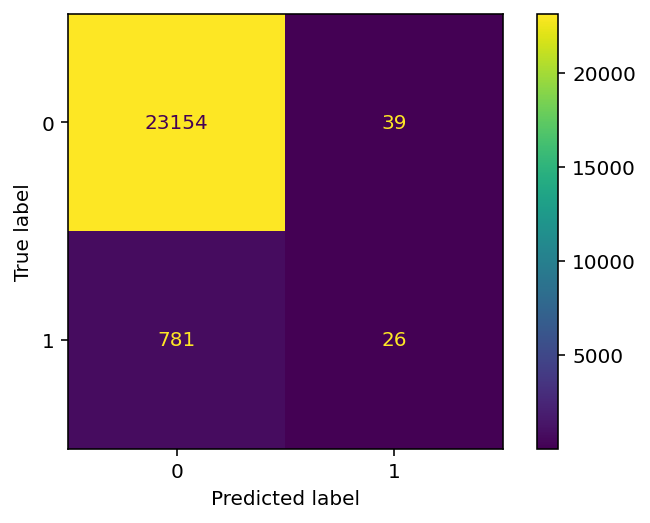

In [60]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model2, x_valid, y_valid)
plt.show()

<span style="color:red">
    Utiliser des cellules markdown pour ajouter des commentaires
</span>

Nous voyons que les 2 premiers modeles de classifieur qui sont random forest et LogisticRegression, on ne peut pas predire le resultat en revanche pour le model de naive Gaussian il y a beaucoup de 1 pour la prédiction

### Code : Essayez d'améliorer votre score

* Data augmentation (optionnel)

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant. Une approche typique est la génération de données (voir cours : `part-6-slides.pdf`). Une des méthodes de génération est [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) (voir cours théorique), elle est notamment implémentée dans le module `imblearn`.

`imblearn` a été développé pour s'interfacer facilement avec `sklearn`.
Il propose notamment une version du `pipeline` qui permet l'intégration avec `sklearn`.

Ci-dessous voici un exemple de `pipeline` intégrant `imblearn` et `sklearn`.

<span style="color:red">
    Répondre ci-dessous
</span>

In [61]:
# TODO: Data augmentation

model = ensemble.HistGradientBoostingClassifier()

pipe = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model),
    ]
)

pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")
y_valid.value_counts()

Balanced accuracy score: 0.625


0    23193
1      807
dtype: int64

In [62]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=1)
pi = imblearn.pipeline.Pipeline(
    [
        ("scale", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA()),
        ("resample", imblearn.over_sampling.SMOTE()),
        ("model", model_knn),
    ]
)
pi.fit(x_train, y_train)

y_predi = pipe.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_predi)  # scoring

print(f"Balanced accuracy score: {score:.3g}")
y_valid.value_counts()

Balanced accuracy score: 0.625


0    23193
1      807
dtype: int64

### Explication de ce que vous avez réalisé, conclusion et perspectives

* Commencez par donner votre meilleur résultat obtenu lors de vos soumissions

* Expliquez le chemin qui vous y a conduit

    * Ce que vous avez essayé :

        * Ce qui a fonctionné

        * Ce qui n'a pas fonctionné et comment vous l'avez solutionné

    * Quelle méthode avez-vous utilisée pour choisir les hyperparamètres ?

    * Comparer la durée d'entrainement des principaux modèles utilisés ?

* Qu'auriez-vous fait si vous aviez eu plus de temps ?

<span style="color:red">
    Répondre ci-dessous
</span>

Notre meilleur resultat obtenu est : 0,61 après avoir essayé de l'ameliorer
pour pouvoir avoir ce résultat, nous avons commencé par faire une analyse Exploratoire avec le genre et les assurances en produisant les graphiques pour ces derniers. Nous avons décidé de choisir Assurance et genre car les données semblait simple par rapport à la religion ou autre qui contenait beaucoup de donnée. Nous avons fais des pie charts et nous en avons conclus que les hommes representaient la plupart des patients et que ces patients avait des assurance dites " Medical"

Pour la correlation nous obtenions beaucoup de données à exploiter alors nous avons décidé de nous concentrer sur une petite partie et certaines valeurs sont plus correlé que d'autres.

Ensuite nous avons eu recours au pre-traitement. On a essayé de traité les valeurs manquantes vue à la correlation.
Nous avons simplifier les données en regroupant par exemple les catégories rares : le language.

De plus, nous avons utilisé le PCA ou ACP comme vu dans le TP4, pour réduire le nombre de dimensions. Nous proposons alors un graphique qui représente les 2 premières dimensions de la PCA qui montre qu'il n'y a pas beaucoup de mort par rapport au vivant au sejour à l'hopital.

On a ensuite entrainé le modèle avec l'aide de 4 classifieurs (dont 2 étaient deja fournis).
Puis, nous utilisons la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats) vu egalement au TP4. Nous l'avons ensuite representer avec l'aide d'un graphique.


Pour 2 modèle il fallait egalement mesurez l'aire sous la courbe ROC (AUC) à l'aide de la fonction de Scikit-Learn. Par la suite, nous comparons les modèles avec leur combinaison respective d'hyperparamètres offrant le meilleur résultat. Nous remarquons : En utilisant les 2 modèles vue plus haut, que le score varie peu.

La matrice de confusion, ouvre un point, c'est que peu importe les modèles de classification utilisé, deux d'entre eux ne peux vraiment predire la mort excepté pour model de naive Gaussian il y a beaucoup de 1 pour la prédiction.

Pour finir dans cette analyse et essayer de participer au challenge nous tentons d'ameliorer notre score de 0,61. Nous tentons alors avec le modèle de KNN malheureusement, je ne peux voir si le resultat à marché car les cellules prennent beaucoup de temps à charger. A notre avis, le score finale ne changera pas plus que ca.

Nous avons eut des problèmes au debut pour l'import de imblearn mais nous avons trouvé la solution plutot facilement. Vers la fin de notre travail, nous avons été confronté à des problème sur le chargement des cellules qui prennent un temps fou à etre executé. Nous travaillons sur Jupyterhub, peut-etre que cela joue. Si nous avions plus de temps on aurait tenté d'ameliorer le score. Au debut nous avons eut quelques problèmes à comprendre ce qui etait demandé, mais grace au TP et les explications des professeurs nous avons pu mener à bien ce projet. Il fallait aussi chercher les ressources sur internet ou on n'avait pas toute les informations.

### Question (optionnelle)

* Qu'est-ce que le suréchantillonnage ? 

* En quoi pourrait-il être utile dans ce problème ?

<span style="color:red">
    Répondre ci-dessous
</span>

Des fois nous avons des classifiers dit "déséquilibré", c'est pourquoi nous avons besoin du sur-echntillonage. 
Il fonctionnent en augmentant le nombre d’observations de les classe(s) minoritaire(s) afin d’arriver à un ratio classe minoritaire & classe majoritaire plutot satisfaisant.
en autre terme, il consiste à échantillonne à une fréquence élevée
Il pourrait être utile dans l'analyse exploratoire pour regulariser!;

## 7. Enregistrer les prédictions

* Utilisez le code suivant pour faire des prédictions et pour les enregistrer sous forme de fichier ZIP
* Soumettez ce fichier ZIP sur [le site du challenge](https://competitions.codalab.org/competitions/30715#participate-submit_results)
("Participate > Submit/View Results > Submit")
* Faites de votre mieux pour être le ***premier sur le leaderboard !***

<span style="color:red">
    !! Ne pas oublier de modifier la commande de la prédiction selon les données et modèles choisis !!
</span>

* Données : `x_test_fact_df`, `x_test_oh_df`

* Modèles : `model`, `search` (e.g., pour le `GridSearchCV`)

In [ ]:
predictions = model.predict(x_test_oh_df)  # compute predictions
# VARS: x_test_df, x_test_fact_df, x_test_oh_df, x_test_1hot_pcs
# Models: model, search


PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---